In [50]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Sat Jan 24 17:34:11 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr  

np.float64(-0.039641400885220335)

In [92]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 100,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.005,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#


In [43]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc import mpi_jax, sampling
import time

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [93]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#


# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 100
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.005
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [38]:
from ad_afqmc import linalg_utils
from jax import lax

# @partial(jit, static_argnums=(0, 1))
# def propagate_free(prop, trial, ham_data, prop_data, fields, wave_data):
#     shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
#     constants = jnp.einsum(
#         "sw,s->sw",
#         jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
#         jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
#     )
#     prop_data["walkers"] = prop._apply_trotprop(
#         ham_data, prop_data["walkers"], fields
#     )
#     prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
#     prop_data, norms = prop._orthogonalize_walkers(prop_data)
#     prop_data["norms"] *= norms[0] * norms[1]
#     prop_data["overlaps"] = (
#         trial.calc_overlap(prop_data["walkers"], wave_data) * prop_data["norms"]
#     )
#     normed_walkers, _ = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
#     prop_data["normed_overlaps"] = trial.calc_overlap(normed_walkers, wave_data)
#     return prop_data

@partial(jit, static_argnums=(3, 4))
def _step_scan_free(prop_data, fields, ham_data, prop, trial, wave_data):
    """Free propagation scan function over steps."""
    prop_data = propagate_free(prop, trial, ham_data, prop_data, fields, wave_data)
    return prop_data, fields

@partial(jit, static_argnums=(3, 4, 6))
def _block_scan_free(prop_data, _x, ham_data, prop, trial, wave_data, sampler):
    """Block scan function for free propagation."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: _step_scan_free(
        x, y, ham_data, prop, trial, wave_data
    )
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    # energy_samples = jnp.where(jnp.abs(energy_samples - ham_data['ene0']) > jnp.sqrt(2./propagator.dt), ham_data['ene0'],     energy_samples)
    block_energy = jnp.sum(energy_samples * prop_data["overlaps"]) / jnp.sum(
        prop_data["overlaps"]
    )
    block_weight = jnp.sum(prop_data["overlaps"])
    return prop_data, (prop_data, block_energy, block_weight)

@partial(jit, static_argnums=(0, 1, 3, 5))
def propagate_free(sampler, ham, ham_data, prop, prop_data, trial, wave_data):
    def _block_scan_free_wrapper(x, y):
        return _block_scan_free(x, y, ham_data, prop, trial, wave_data, sampler)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data, (prop_data_tr, block_energy, block_weight) = lax.scan(
        _block_scan_free_wrapper, prop_data, None, length=sampler.n_blocks
    )
    return prop_data_tr, block_energy, block_weight, prop_data["key"]

In [94]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0

In [95]:
print(prop_data["e_estimate"])

-1.056429882169736


In [96]:
nstep = 100
fp_e = np.zeros(nstep,dtype=np.complex128)
fp_w = np.zeros(nstep,dtype=np.complex128)
for n in range(nstep):
    prop_data, (_, blk_e, blk_w) = \
        sampler._block_scan_free(prop_data, None, ham_data, prop, trial, wave_data)
    fp_e[n] = blk_e
    fp_w[n] = blk_w
    print(n, blk_e, blk_w)

0 (-1.0628569392287333+0.00020841991963501907j) (132.07857322543208+0.028306881243121168j)
1 (-1.0708064513990059+0.00043741606965184477j) (172.18092054587805+0.1494473758587727j)
2 (-1.0752248696879605+0.0006084511508469045j) (226.59838372034534+0.5632183252481798j)
3 (-1.0808517551113046+0.00040617146635329944j) (295.40920794592216+0.7160987507444816j)
4 (-1.0828975296823866+0.00028076216336659455j) (389.8728728592175+0.8667250796193716j)
5 (-1.086364194810259+0.0015728296113075599j) (509.39052046585334+2.1450648314657084j)
6 (-1.0892052041005649-3.6977749334856096e-05j) (666.0860605402395+2.5663444261397443j)
7 (-1.0921862989084392-0.00020928638290815835j) (869.021778101788+3.5505305393977955j)
8 (-1.088486700421761+0.0008997217844858693j) (1167.9617479935437+5.366312893471539j)
9 (-1.088037810811315-0.0009791912856844066j) (1548.0717289836955+0.48339322810054797j)
10 (-1.0941945578311636-0.0038400695592635085j) (1989.6781048943187-9.334614781855056j)
11 (-1.098041684811433-0.002589

In [87]:
sum(prop_data["overlaps"])

Array(2.16270153e+14+1.12457598e+13j, dtype=complex128)

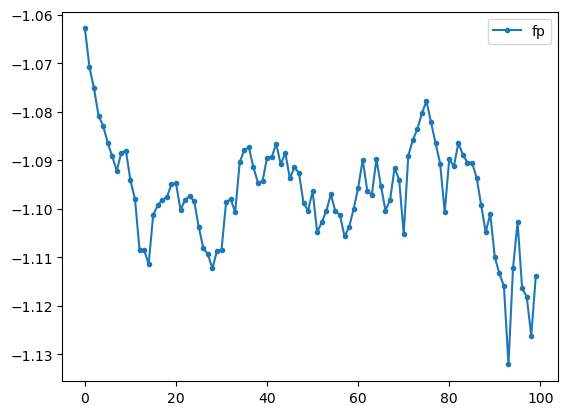

In [97]:
from matplotlib import pyplot as plt
# eg_avg = eg_sp.mean()
# eg_avg_std = np.std(eg_sp, ddof=1) / np.sqrt(len(eg_sp))
# et_avg = np.sum(wp_sp * et_sp) / np.sum(wp_sp)
# et_avg_std = np.std(et_sp, ddof=1) / np.sqrt(len(et_sp))

# print(f'AFQMC/Guide=CISD average = {eg_avg}, std = {eg_avg_std}')
# print(f'AFQMC/Trial=RHF  average = {et_avg}, std = {et_avg_std}')

plt.plot(fp_e.real,'.-',label='fp',color='C0')
# plt.plot([eg_avg]*len(eg_sp),'--',color='C0')
# plt.plot(et_sp,'.-',label='Trial(RHF)',color='C1')
# plt.plot([et_avg]*len(et_sp),'--',color='C1')

plt.legend()
plt.show()

In [99]:
@partial(jit, static_argnums=(0, 4, 5))
def _block_scan_abs(sampler, prop_data, _x, ham_data, prop, trial, wave_data):
    """Block scan function for free propagation."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: sampler._step_scan_free(
        x, y, ham_data, prop, trial, wave_data
    )
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    # energy_samples = jnp.where(jnp.abs(energy_samples - ham_data['ene0']) > jnp.sqrt(2./propagator.dt), ham_data['ene0'],     energy_samples)
    block_energy = jnp.sum(energy_samples * jnp.abs(prop_data["overlaps"])) / jnp.sum(
        jnp.abs(prop_data["overlaps"])
    )
    block_weight = jnp.abs(jnp.sum(prop_data["overlaps"]))
    return prop_data, (prop_data, block_energy, block_weight)

In [98]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
print(prop_data["e_estimate"])

-1.056429882169736


In [100]:
nstep = 100
abs_e = np.zeros(nstep,dtype=np.complex128)
abs_w = np.zeros(nstep,dtype=np.complex128)
for n in range(nstep):
    prop_data, (_, blk_e, blk_w) = \
        _block_scan_abs(sampler,prop_data, None, ham_data, prop, trial, wave_data)
    abs_e[n] = blk_e
    abs_w[n] = blk_w
    print(n, blk_e, blk_w)

0 (-1.0628548079724716+0.00022186128123466472j) 132.07857625877617
1 (-1.070789006715118+0.0005011792413197204j) 172.18098540356922
2 (-1.0751889439518254+0.0007410359176408365j) 226.59908366883298
3 (-1.080792857967335+0.0006805496108808201j) 295.41007588885304
4 (-1.082846849070784+0.0006017462619706079j) 389.87383626484
5 (-1.0861595169782048+0.0025640027744516167j) 509.3950369247861
6 (-1.0889875541636962+0.0012440573716343605j) 666.0910044203639
7 (-1.0914919640850562+0.002338336444931801j) 869.0290312079939
8 (-1.0854873903742586+0.0006927983090885861j) 1167.9740759495498
9 (-1.0859581132511422-0.003078873290319137j) 1548.071804454684
10 (-1.0932692648152518-0.0034731059992184846j) 1989.7000015401754
11 (-1.0970276656408227-0.002319210278354579j) 2572.423341411332
12 (-1.1061584879062771-0.004475340911310696j) 3221.665524196094
13 (-1.1025638922552146-0.00020046006979387846j) 4198.24544801532
14 (-1.1074775964017107-0.0016353934119798452j) 5403.93845775782
15 (-1.0969603402205494

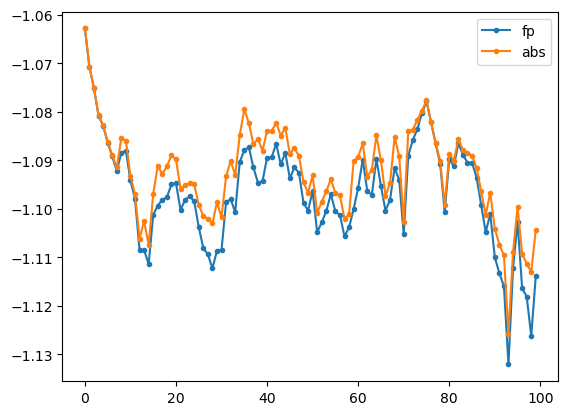

In [101]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(abs_e.real,'.-',label='abs',color='C1')

plt.legend()
plt.show()